In [64]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

N = 1000
np.random.seed(1)

weight = np.random.uniform(low=1, high=7, size=(N,))
age = np.random.uniform(low=1, high=100, size=(N,)) # some influence on size
geneA = np.random.beta(a=1, b=6, size=(N,)) # small influence on size
#geneA = np.random.uniform(low=1000, high=10000, size=(N,)) # small influence on size
geneB = np.random.beta(a=7, b=2, size=(N,)) # big influence on size
#geneB = np.random.uniform(low=.01, high=1, size=(N,)) # big influence on size
geneC = np.random.uniform(low=1, high=10000, size=(N,)) # no influence on size
geneD = np.random.uniform(low=1, high=10, size=(N,)) # no influence on size by itself but only in interaction with weight
noise = np.random.uniform(low=-3, high=3, size=(N,))

size = 0.2*(-((weight-5)**2) - 0.45*(weight*geneD) + age*.4 + 100*(geneA) - 2*geneB) +15 +noise
df = pd.DataFrame(data={"weight": weight, "age": age,
                        "geneA": geneA, "geneB": geneB,
                        "geneC": geneC, "geneD": geneD, "size": size});

print(df.describe())

            weight          age        geneA        geneB        geneC  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      4.003628    52.293127     0.143755     0.771224  5109.075363   
std       1.731004    29.046015     0.123326     0.137063  2836.360708   
min       1.000686     1.075674     0.000038     0.281561     3.922193   
25%       2.511608    26.161615     0.047764     0.690603  2771.614381   
50%       4.045005    53.834163     0.111681     0.792516  5200.202793   
75%       5.504028    78.240582     0.207673     0.877588  7504.985509   
max       6.983937    99.853530     0.671308     0.987966  9988.047397   

             geneD         size  
count  1000.000000  1000.000000  
mean      5.543123    18.902511  
std       2.627076     3.959209  
min       1.000424     6.748268  
25%       3.250677    16.180964  
50%       5.582402    18.699940  
75%       7.863682    21.473181  
max       9.995096    31.716837  


Computing correlations...


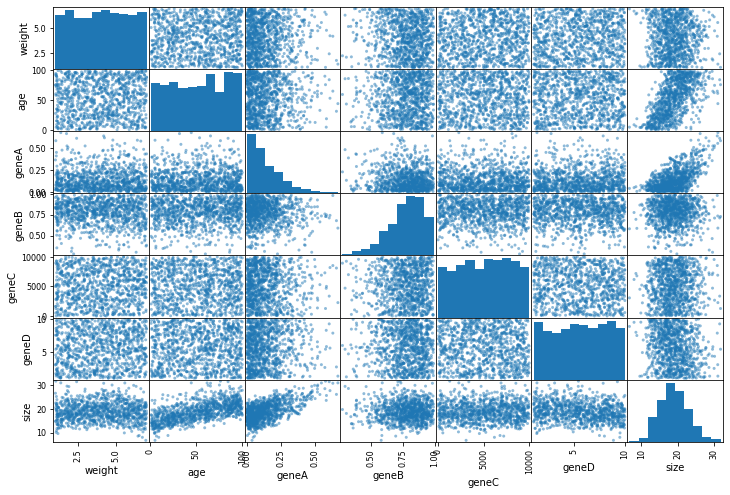

In [65]:
from pandas.plotting import scatter_matrix
print("Computing correlations...");
scatter_matrix(df, figsize=(12, 8));

df.to_csv('datasets/rats-obesity-genes.csv', sep = ',', index = False)
rats = pd.read_csv("datasets/rats-obesity-genes.csv")

In [66]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(rats["weight"], rats["size"], test_size=0.3, random_state=42);
print("Splitting data to training and test set with stratification:")
bins = np.linspace(10, 25, 5)
# Save discretized Y values in a new array, broken down by the bins created above.
strat = np.digitize(rats["size"], bins)
L, T = train_test_split(rats, test_size=0.3, random_state=42, stratify=strat)
print("Learning set size: {:d}\nTest set size: {:d}".format(len(L), len(T)))

Splitting data to training and test set with stratification:
Learning set size: 700
Test set size: 300


Separate the independent variables from L and T:

In [67]:
X_train = L.drop("size", axis=1)
y_train = L["size"].copy()

X_test = T.drop("size", axis=1)
y_test = T["size"].copy()

In [113]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

pf = PolynomialFeatures()
lr = LinearRegression()
#lr = LassoLars()
#lr = Ridge()

poly_lr_model = Pipeline([('poly', pf), ('linear', lr)])
parameters = {'poly__degree': range(2,4),
              'linear__fit_intercept': [True, False],
              'linear__normalize': [True, False],
              #'linear__alpha': np.linspace(0, 1, 20)
             }

grid_search = GridSearchCV(poly_lr_model, parameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    #print(np.sqrt(-mean_score), params)
    pass

print(grid_search.best_params_)

print("Final testing...")
final_model = grid_search.best_estimator_

{'linear__fit_intercept': False, 'linear__normalize': True, 'poly__degree': 2}
Final testing...


In [114]:
from sklearn.metrics import mean_squared_error, r2_score

y_final = final_model.predict(X_test)
print("Model performance on TEST data:")
print("Mean squared error: {:.2f}".format(mean_squared_error(y_test, y_final) ))
print('Variance score: {:.2f}\n'.format(r2_score(y_test, y_final) ))

y_final_train = final_model.predict(X_train)
print("Model performance on TRAIN data:")
print("Mean squared error: {:.2f}".format(mean_squared_error(y_train, y_final_train) ))
print('Variance score: {:.2f}'.format(r2_score(y_train, y_final_train) ))

Model performance on TEST data:
Mean squared error: 3.25
Variance score: 0.80

Model performance on TRAIN data:
Mean squared error: 3.03
Variance score: 0.80


In [111]:
lr_final = final_model['linear']
cfs = lr_final.coef_
print(cfs)

[ 0.00000000e+00  2.90158430e+00  8.01622435e-02  1.69738604e+01
 -4.21813982e+00 -1.80097449e-04  2.11123000e-01 -2.50138702e-01
  7.30107845e-04  8.92855693e-02 -7.23479271e-01  1.51207919e-06
 -8.62567297e-02 -1.59546366e-04 -1.75416833e-03  2.41689604e-02
  6.70413845e-08 -1.00623077e-03  2.50508570e+00  3.20343926e+00
 -1.53945705e-04 -1.22353975e-01  1.96269463e+00  3.47681236e-04
  1.19226740e-01  5.87699664e-10 -9.74551617e-06 -1.61931222e-02]


In [94]:
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

models = [final_model,
          KNeighborsRegressor(n_neighbors=5),
          DecisionTreeRegressor(random_state=42),
          RandomForestRegressor(n_estimators=10, random_state=42),
          LassoLars(alpha=.07),
          Ridge(alpha=.5),
         ]
for m in models:
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE:{err:7.2f}".format(err=final_rmse))

RMSE:   1.80
RMSE:   3.74
RMSE:   2.70
RMSE:   1.99
RMSE:   3.40
RMSE:   1.81


In [95]:
print(models[4].coef_)
print(models[5].coef_)

[0.         0.01641257 4.21373844 0.         0.         0.        ]
[-6.17286505e-02  8.05168768e-02  1.86038695e+01  5.60740166e-02
  1.86236831e-05 -3.23966993e-01]
